In [1]:
import numpy as np

from abm_models import make

from abm_models.models.cats import CatsModel

from black_it.calibrator import Calibrator
from black_it.loss_functions.msm import MethodOfMomentsLoss
from black_it.samplers.best_batch import BestBatchSampler
from black_it.samplers.gaussian_process import GaussianProcessSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.xgboost import XGBoostSampler

from black_it.utils.time_series import log_and_hp_filter, diff_log_demean_filter

import matplotlib.pyplot as plt

In [95]:
cats_model = make("CatsModel", 
                  path_to_cats_directory= "/Users/aldoglielmo/DRTA_code/AgenC",
                 W=500, F= 50, N= 10, 
                  warm_up_samples = 200,
                 output_variables= ["Y_real","gdp_deflator","Investment","consumption","Un"])#, fixtures= DEFAULT_PARAMS)


In [3]:
# import the target data, the US economy from 1947 to 2019
real_data = np.genfromtxt('FRED_data.txt')
target_labels = ["gdp gap","inflation rate","investment gap","consumption","unemployment"]

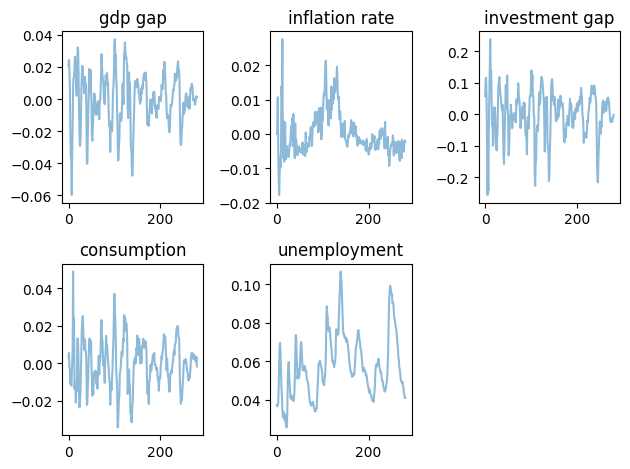

In [4]:
# the target time series
fig, axes = plt.subplots(2, 3)

i = 0
for line in axes:
    for ax in line:
        if i<5:
            ax.set_title(target_labels[i])
            ax.plot(real_data[:, i], alpha = 0.5)
        else:
            ax.axis('off')
        
        i+=1

plt.tight_layout()

In [87]:
# previously found parameters
found_params = {
'Iprob':0.36,
'chi':0.069,
'delta':0.956,
'inventory_depreciation':0.764,
'mu':1.3769999999999587,
'p_adj':0.089,
'phi':0.016,
'q_adj':0.8160000000000003,
'tax_rate':0.002,
'theta':0.044,
'xi':0.8810000000000003}

In [6]:
# try to run the ABM with some parameters
output = cats_model.run(params = dict(Iprob = 0.25,
         chi = 0.05,
         delta = 0.5,
         inventory_depreciation= 0.3,
         mu = 1.2,
         p_adj = 0.1,
         phi = 0.002,
         q_adj = 0.9,
         tax_rate = 0.05,
         theta = 0.05,
         xi = 0.96), 
         nb_samples = 281, seed = 0)

┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300


Text(0, 0.5, 'real gdp')

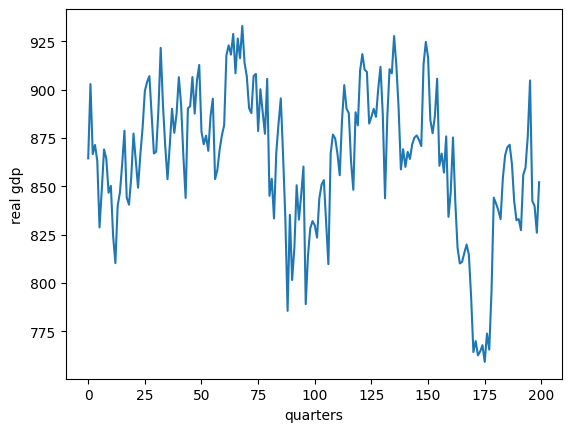

In [101]:
# plot one of the obtained series
plt.plot(output[:, 0])
plt.xlabel('quarters')
plt.ylabel('real gdp')

In [11]:
# define a simple model wrapper
def model_wrapper(theta, N, seed):
    output = cats_model.run(params=
    dict(
    Iprob=theta[0],
    chi=found_params['chi'],
    delta=found_params['delta'],
    inventory_depreciation=theta[1],
    mu=theta[2],
    p_adj=found_params['p_adj'],
    phi=found_params['phi'],
    q_adj=found_params['q_adj'],
    tax_rate = found_params['tax_rate'],
    theta=found_params['theta'],
    xi=found_params['xi']),
    nb_samples=N, 
    seed=seed)
    return output


In [12]:
# define a method of moments loss function with some coordinate filters
coordinate_filters = [log_and_hp_filter, 
                      diff_log_demean_filter, 
                      log_and_hp_filter, 
                      log_and_hp_filter, 
                      None]

loss = MethodOfMomentsLoss(coordinate_filters = coordinate_filters, 
                           covariance_mat= "identity",
                           standardise_moments= True)


In [13]:
# define the simulation bounds and precisions
# bounds = np.array([
#         [0.0, 0.5],
#         [0.0, 0.1],
#         [0.0, 1.0],
#         [0.0, 1.0],
#         [1.0, 1.5],
#         [0.0, 0.5],
#         [0.0, 0.1],
#         [0.5, 1.0],
#         [0.0, 0.4],
#         [0.0, 0.15],
#         [0.5, 1.0]]).T

# precisions = [0.001] * 11 


bounds = np.array([
        [0.0, 0.5],
        [0.0, 1.0],
        [1.0, 1.5]]).T

precisions = [0.001] * 3 


In [105]:
# define a list of search methods, one just for seeding
seed_sampler = [HaltonSampler(batch_size=4)]
adaptive_sampler = [RandomForestSampler(batch_size=4)]

In [103]:
# folter where data are saved
saving_folder = "CATS_model_output"

# length of the simulations
sim_length = 300
ensemble_size = 1 #@ANTONIO: increase this to 4 for target calibration

# initialize the Calibrator
cal = Calibrator(
    samplers=seed_sampler,
    real_data=real_data,
    sim_length=sim_length,
    model=model_wrapper,
    parameters_bounds=bounds,
    parameters_precision=precisions,
    ensemble_size=ensemble_size, 
    loss_function=loss,
    saving_folder=saving_folder,
    random_state=0,
    n_jobs=1 #@ANTONIO: increase this to batch_size*ensemble_size for target calibration 
             #(e.g., batch_size = 8, ensemble_size = 4, n_jobs=32)
)


***
Number of free params:       3.
Explorable param space size: 251252001.
***

Selecting 1 processes for the parallel evaluation of the model


In [104]:
# sample some initial seed points uniformly using a Halton sampler
params, losses = cal.calibrate(1)


BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HaltonSampler


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500
----> sim exec elapsed time: 16.3s
---->   min loss new params: 16.34
---->   avg loss new params: 34.86
----> avg loss exist params: 34.86
---->         curr min loss: 16.337306031010556
====>    total elapsed time: 16.3s

METHOD: RandomForestSampler


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500
----> sim exec elapsed time: 34.5s
---->   min loss new params: 24.0
---->   avg loss new params: 53.27
----> avg loss exist params: 47.13
---->         curr min loss: 16.337306031010556
====>    total elapsed time: 35.7s
Checkpoint saved in 0.0s


In [108]:
# change the samplet to a more adaptive sampler
cal.set_samplers(adaptive_sampler)

In [109]:
# calibrate for a number of epochs
cal.calibrate(1)


BATCH NUMBER:   2
PARAMS SAMPLED: 6

METHOD: RandomForestSampler


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents ~/.julia/packages/Agents/QtIUJ/src/core/model.jl:299


T: 100
T: 200
T: 300
T: 400
T: 500
----> sim exec elapsed time: 30.4s
---->   min loss new params: 22.09
---->   avg loss new params: 32.94
----> avg loss exist params: 41.46
---->         curr min loss: 16.337306031010556
====>    total elapsed time: 31.4s
Checkpoint saved in 0.0s


(array([[0.396, 0.698, 1.362],
        [0.493, 0.842, 1.382],
        [0.3  , 0.929, 1.485],
        [0.346, 0.479, 1.391],
        [0.255, 0.539, 1.283],
        [0.415, 0.235, 1.328],
        [0.457, 0.487, 1.374],
        [0.084, 0.142, 1.462],
        [0.11 , 0.775, 1.15 ],
        [0.093, 0.768, 1.281]]),
 array([16.33730603, 22.09262398, 23.52945006, 23.99529512, 24.13964858,
        40.74720127, 45.40242398, 53.38616526, 75.16243095, 89.76476363]))

In [110]:
# find the best loss index
best_idx = np.argmin(cal.losses_samp)

In [111]:
# retrieve the best loss simulations
best_sim = cal.series_samp[best_idx]

In [112]:
from black_it.utils.time_series import log_and_hp_filter, diff_log_demean_filter
from black_it.utils.time_series import get_mom_ts, get_mom_ts_1d
import seaborn as sns
cmap = plt.get_cmap("tab10")
filters = [log_and_hp_filter, diff_log_demean_filter, log_and_hp_filter, log_and_hp_filter, lambda x: x]

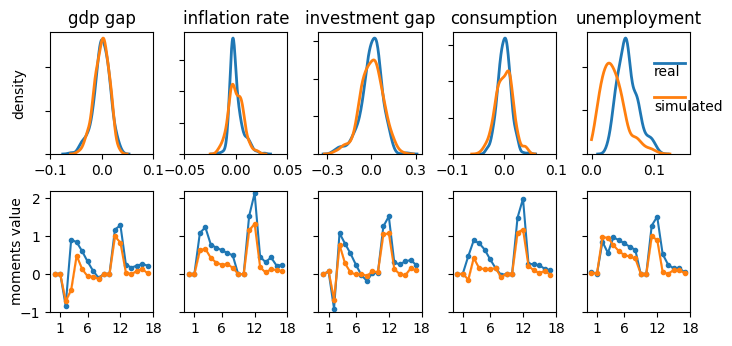

<Figure size 640x480 with 0 Axes>

In [113]:
# confront real and simulated moments
fig, axes = plt.subplots(2, 5, figsize=(8, 3.5))

xlabels_kde = [[-0.1, 0.0, 0.1 ], [-0.05, 0, 0.05], [-0.3, 0, 0.3],[-0.1, 0, 0.1], [0., 0.1, 0.2], ]
clips = [(-0.1, 0.1), (-0.1, 0.1), (-0.4, 0.4), (-0.1, 0.1), (0.0, 0.25)]

for i in range(5):
    ### DATA ##:
    filter_ = filters[i]
    filtered_data = np.array([filter_(best_sim[j, :, i]) for j in range(ensemble_size)])
    
    real_moments = get_mom_ts_1d(real_data[:, i])
    sim_moments = np.array([get_mom_ts_1d(filtered_data[j, :]) for j in range(ensemble_size)]) 
    m = np.mean(sim_moments, axis = 0)
    s = np.std(sim_moments, axis = 0)
    
    ### KDE ###
    ax = axes[0, i]
    ax.set_title(target_labels[i])
    sns.kdeplot(ax=ax, data=real_data[:, i], label = 'target', 
                bw_adjust = 1., clip = clips[i], lw = 2)


    sns.kdeplot(ax=ax, data = filtered_data.flatten(), 
                color = cmap(1), label = 'lowest loss', 
                bw_adjust = 1., clip = clips[i], lw = 2)
    
    ax.set_ylabel("")
    ax.set_yticklabels("")
    ax.set_xticks(xlabels_kde[i])
    
    ### MOMENTS ###
    index = np.arange(len(real_moments))
    ax = axes[1, i]
    ax.set_ylim(-1, 2.2)
    ax.plot(index, real_moments, '-o', ms = 3)

    ax.plot(index, m, color = cmap(1), ls = '-',marker = 'o', ms = 3)
    ax.fill_between(index, m - s, m + s, alpha = 0.25, color = cmap(1))
    ax.set_xticks([1, 6, 12, 18])
    ax.set_xlabel("")
    
axes[0, 0].set_ylabel("density", labelpad= 10)
axes[1, 0].set_ylabel("moments value", labelpad= -3)

for i in range(1, 5):
    axes[1, i].set_yticklabels("")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)


axes[0, 4].plot([0.1, 0.15],[21, 21], lw = 2, color = cmap(0))
axes[0, 4].text(0.1,18,"real")


axes[0, 4].plot([0.1, 0.15],[13, 13], lw = 2, color = cmap(1))
axes[0, 4].text(0.1,10,"simulated")

plt.show()

plt.savefig("kde_moments.png", dpi = 300)

## Sanity check: run model with found_params and check results

In [ ]:
best_output = cats_model.run(params = dict(
         Iprob = found_params['Iprob'],
         chi = found_params['chi'],
         delta = found_params['delta'],
         inventory_depreciation= found_params['inventory_depreciation'],
         mu = found_params['mu'],
         p_adj = found_params['p_adj'],
         phi = found_params['phi'],
         q_adj = found_params['q_adj'],
         tax_rate = found_params['tax_rate'],
         theta = found_params['theta'],
         xi = found_params['xi'])
         , nb_samples = 800, seed = 2)

In [ ]:
best_sim = np.array([best_output])

In [114]:
total_loss = 0.0

for i in range(5):
    filter_ = filters[i]
    real_moments = get_mom_ts_1d(real_data[:, i])
    sim_moments = np.array([get_mom_ts_1d(filter_(best_sim[j, :, i])) for j in range(ensemble_size)])
    
    sim_moments = sim_moments / (abs(real_moments)[None, :])
    real_moments = real_moments / abs(real_moments)
    
    total_loss += np.sum((real_moments - np.mean(sim_moments, axis=0))**2)


total_loss/5

16.337306031010556